In [1]:
import shutil
import logging
import warnings
import pandas as pd
from sklearn.metrics import accuracy_score
from ageas import Panel
from ageas.tool import Multimodal_Corpus, make_fake_adata
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import scanpy as sc
from sklearn.metrics import roc_auc_score

/data/jiangjunyao/miniconda3/envs/ageas/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata = sc.read_h5ad('/data/jiangjunyao/easyGRN/processed_data/celltag_multi_iep.prcessed.h5ad')
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True,flavor='seurat_v3')
sc.pp.normalize_total(adata)

In [3]:
adata_test = adata[adata.obs['celltype']=='early']
adata_train = adata[adata.obs['celltype']!='early']

In [4]:
corpus = Multimodal_Corpus(
    adata=adata_train,
    label_key = 'celltype',
    backed=False
)
# Init main Panel
panel = Panel(
    config_folder = '/data/jiangjunyao/fa_result/config_tunning/config_larry_v5',
    verbose = True,
)


In [11]:

deck = panel.n_kfold_selection(
                accelerator = 'cuda',
                query_dataset = corpus,
                kfold_selection_list = [5],
                valid_fraction = 0.1,
        
                monitor_type = 'max',
                monitor_metric = 'test.accuracy',
                min_requirement = 0.5,
                stratified_kfold_test = True,stratified_kfold_valid=True,
                verbose = False)
corpus_test = Multimodal_Corpus(
    adata=adata_test,
    label_key = 'state_info',
    backed=False
)
all_preds, all_labels = deck.predict(query_dataset = corpus_test)

/data/jiangjunyao/miniconda3/envs/ageas/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/jiangjunyao/miniconda3/envs/ageas/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/jiangjunyao/miniconda3/envs/ageas/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | embedder  | Sequential         | 8.0 K  | train
1 | dropout   | Dropout            | 0      | train
2 | fc       

In [12]:
result = []
for label in np.argmax(all_preds, axis=1):
    value = corpus.label_dict.get(label)
    result.append(value)
corpus_test.adata.obs['pred'] = result
corpus_test.adata.obs['prob1'] = all_preds[:, 0]
corpus_test.adata.obs['prob2'] = all_preds[:, 1]

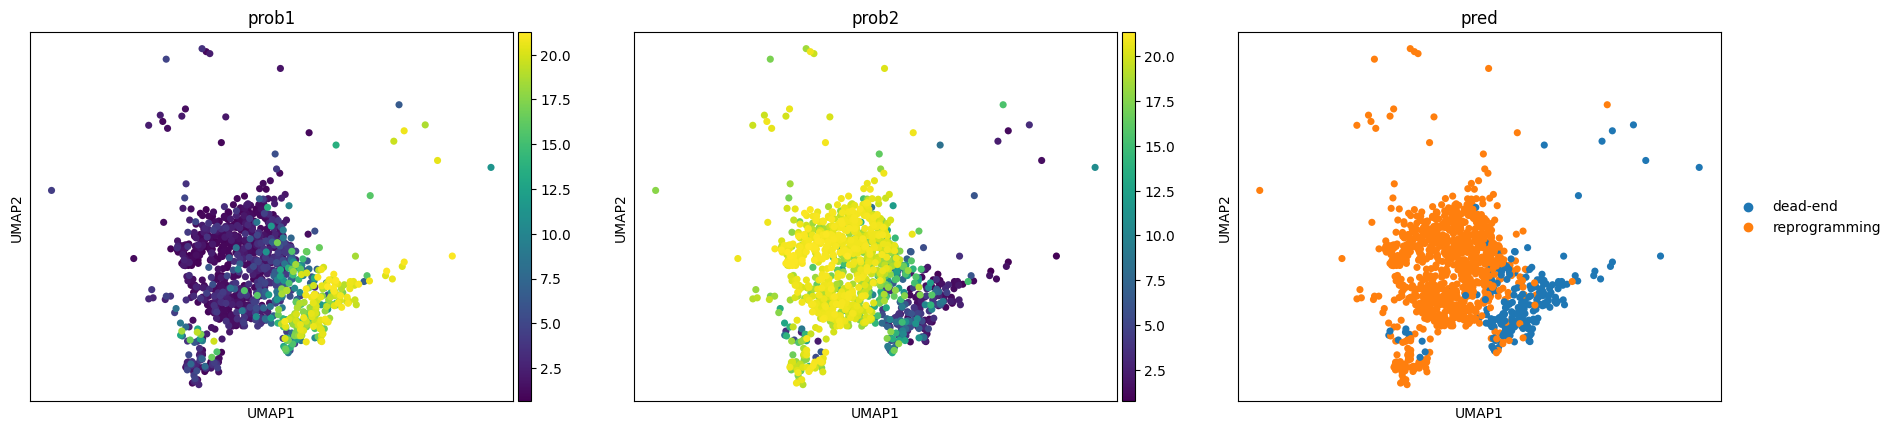

In [13]:
sc.pl.umap(corpus_test.adata,color=['prob1','prob2','pred'])